# Self-driving in Udacity simulator (Behavioural cloning)

In [1]:
import os
import ntpath
import numpy as np
import cv2
import pandas as pd
import random
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
# import tensorflow.keras as k
import keras
import tensorflow as tf
from imgaug import augmenters as iaa
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dropout, Flatten
from keras.layers import Dense
# from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense

In [2]:
config = tf.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.Session(config=config)
keras.backend.tensorflow_backend.set_session(sess)

## Importing data

The data were collect with 3 forward laps and 3 reverse laps for balancing data

- "center", "left", "right" images are features

- "steering" is the target values

In [3]:
data_dir = './data'
columns = ['center', 'left', 'right', 'steering', 'throttle', 'reverse', 'speed']
data = pd.read_csv(os.path.join(data_dir, 'driving_log.csv'), names=columns)
pd.set_option('display.max_colwidth', -1)

In [4]:
def path_leaf(path):
    head, tail = ntpath.split(path)
    return tail

data['center'] = data['center'].apply(path_leaf)
data['left'] = data['left'].apply(path_leaf)
data['right'] = data['right'].apply(path_leaf)

data.head()

,center,left,right,steering,throttle,reverse,speed
0,center_2019_02_10_20_09_13_542.jpg,left_2019_02_10_20_09_13_542.jpg,right_2019_02_10_20_09_13_542.jpg,0.000000,0.020916,0,0.016797
1,center_2019_02_10_20_09_13_643.jpg,left_2019_02_10_20_09_13_643.jpg,right_2019_02_10_20_09_13_643.jpg,0.000000,0.323451,0,0.248754
2,center_2019_02_10_20_09_13_743.jpg,left_2019_02_10_20_09_13_743.jpg,right_2019_02_10_20_09_13_743.jpg,-0.049020,0.619350,0,0.800140
3,center_2019_02_10_20_09_13_844.jpg,left_2019_02_10_20_09_13_844.jpg,right_2019_02_10_20_09_13_844.jpg,-0.348375,0.918705,0,1.758326
4,center_2019_02_10_20_09_13_945.jpg,left_2019_02_10_20_09_13_945.jpg,right_2019_02_10_20_09_13_945.jpg,-0.602155,1.000000,0,3.153421


## EDA

Plotting target values group with 25 bins histrogram and re-center

There are a lot of 0 angle which is make sense because when collecting data in training track, it's forward most of the time.

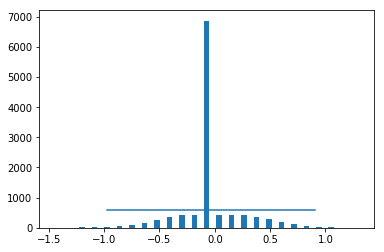

In [5]:
num_bins = 25
samples_per_bin = 600
hist, bins = np.histogram(data['steering'], num_bins)
center = bins[:-1] + bins[1:] * 0.5
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

Randomly remove data above the threshold (which is 400)

total data: 11038
removed: 6268
remaining: 4770


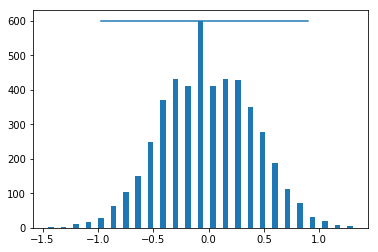

In [6]:
print('total data:', len(data))
remove_list = []
for j in range(num_bins):
    list_ = []
    for i in range(len(data["steering"])):
        if data['steering'][i] >= bins[j] and data['steering'][i] <= bins[j + 1]:
            list_.append(i)
    list_ = shuffle(list_)
    list_ = list_[samples_per_bin:]
    remove_list.extend(list_)

print('removed:', len(remove_list))
data.drop(data.index[remove_list], inplace=True)
print('remaining:', len(data))

hist, _ = np.histogram(data['steering'], num_bins)
plt.bar(center, hist, width=0.05)
plt.plot((np.min(data['steering']), np.max(data['steering'])), (samples_per_bin, samples_per_bin))

## Train / Test data

In [7]:
def load_img_steering(datadir, df):
    image_path = []
    steering = []
    for i in range(len(data)):
        indexed_data = data.iloc[i]
        center, left, right = indexed_data[:3]
        image_path.append(os.path.join(datadir, center.strip()))
        steering.append(float(indexed_data[3]))
        # left image append
        image_path.append(os.path.join(datadir, left.strip()))
        steering.append(float(indexed_data[3])+0.15)
        # right image append
        image_path.append(os.path.join(datadir, right.strip()))
        steering.append(float(indexed_data[3])-0.15)
    image_paths = np.asarray(image_path)
    steerings = np.asarray(steering)
    return image_paths, steerings 

image_paths, steerings = load_img_steering(data_dir + '/IMG', data)

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(image_paths, steerings, test_size=0.2, random_state=6)

Text(0.5,1,'Validation set')

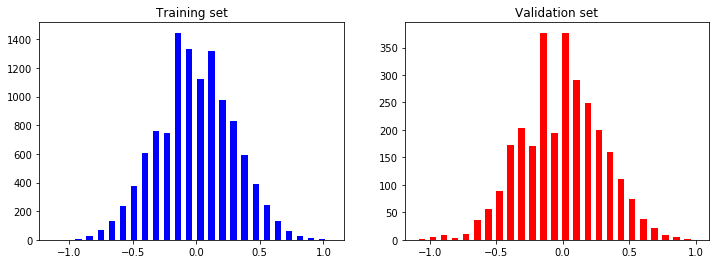

In [9]:
fig, axis = plt.subplots(1, 2, figsize=(12, 4))
axis[0].hist(y_train, bins=num_bins, width=0.05, color='blue')
axis[0].set_title("Training set")
axis[1].hist(y_valid, bins=num_bins, width=0.05, color='red')
axis[1].set_title("Validation set")

## Image augmentation

In [10]:
def zoom(image):
    zoom_ = iaa.Affine(scale=(1, 1.3))
    image = zoom_.augment_image(image)
    return image

Text(0.5,1,'Zoomed')

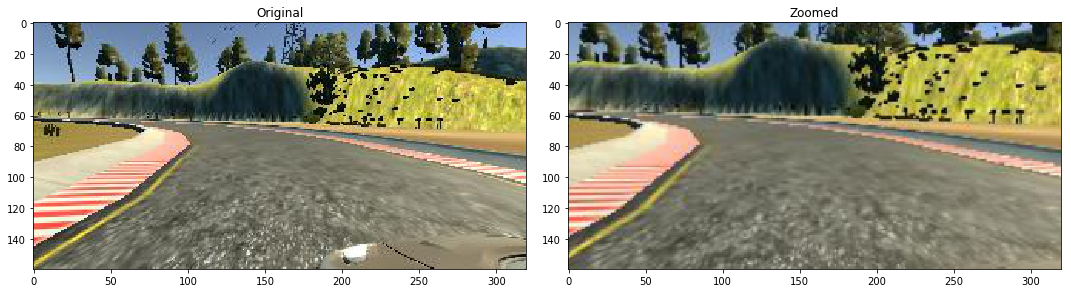

In [11]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
zoomed_image = zoom(original_image)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original')
axis[1].imshow(zoomed_image)
axis[1].set_title('Zoomed')

In [12]:
def pan(image):
    pan_ = iaa.Affine(translate_percent={"x": (-0.1, 0.1), "y": (-0.1, 0.1)})
    image = pan_.augment_image(image)
    return image


Text(0.5,1,'Panned')

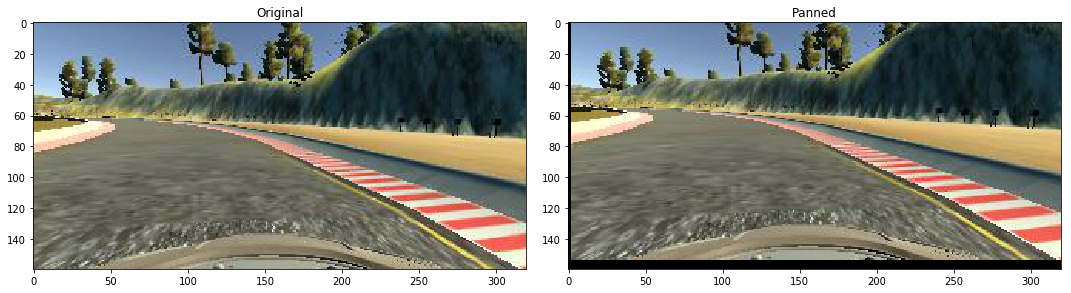

In [13]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
panned_image = pan(original_image)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original')
axis[1].imshow(panned_image)
axis[1].set_title('Panned')

In [14]:
def img_random_brightness(image):
    brightness = iaa.Multiply((0.2, 1.2))
    image = brightness.augment_image(image)
    return image

Text(0.5,1,'Brightnessed')

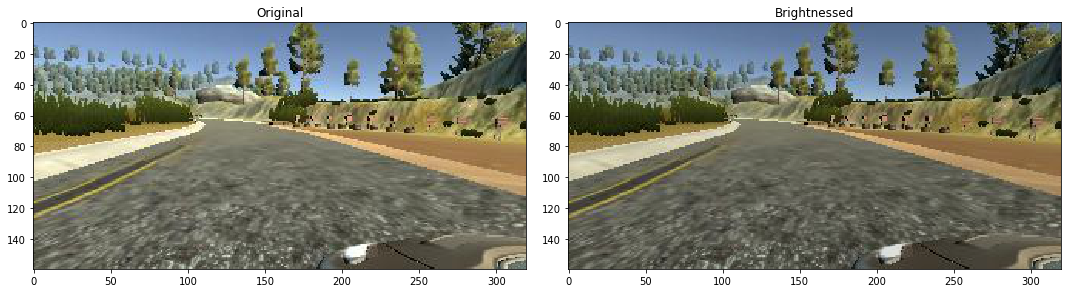

In [15]:
image = image_paths[random.randint(0, 1000)]
original_image = mpimg.imread(image)
brightess_image = img_random_brightness(original_image)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original')
axis[1].imshow(brightess_image)
axis[1].set_title('Brightnessed')

In [16]:
def img_random_flip(image, steering_angle):
    image = cv2.flip(image, 1)
    steering_angle = -steering_angle  # Also, steering angle need to be flipped
    return image, steering_angle

Text(0.5,1,'Flipped, Steering angle -0.15')

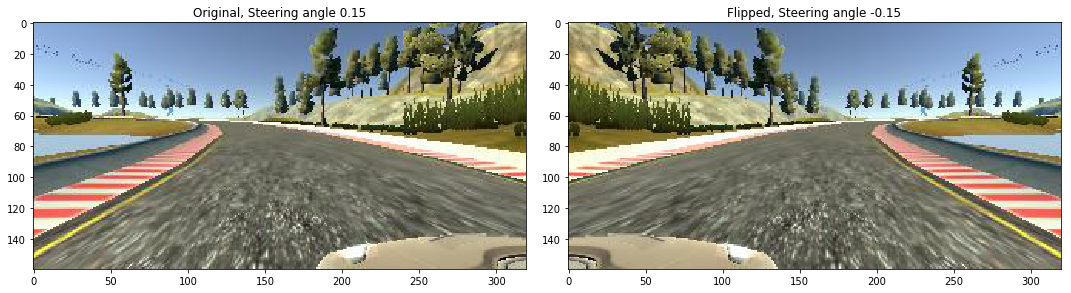

In [17]:
random_index = random.randint(0, 1000)
image = image_paths[random_index]
steering_angle = steerings[random_index]

original_image = mpimg.imread(image)
flipped_image, flipped_steering_angle = img_random_flip(original_image, steering_angle)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title('Original, ' + 'Steering angle ' + str(steering_angle))
axis[1].imshow(flipped_image)
axis[1].set_title('Flipped, ' + 'Steering angle ' + str(flipped_steering_angle))

There is no need to apply all augments to all images.

50% chance for random augments

In [18]:
def random_augment(image, steering_angle):
    image = mpimg.imread(image)
    if np.random.rand() < 0.5:
        image = pan(image)
    if np.random.rand() < 0.5:
        image = zoom(image)
    if np.random.rand() < 0.5:
        image = img_random_brightness(image)
    if np.random.rand() < 0.5:
        image, steering_angle = img_random_flip(image, steering_angle)
    return image, steering_angle

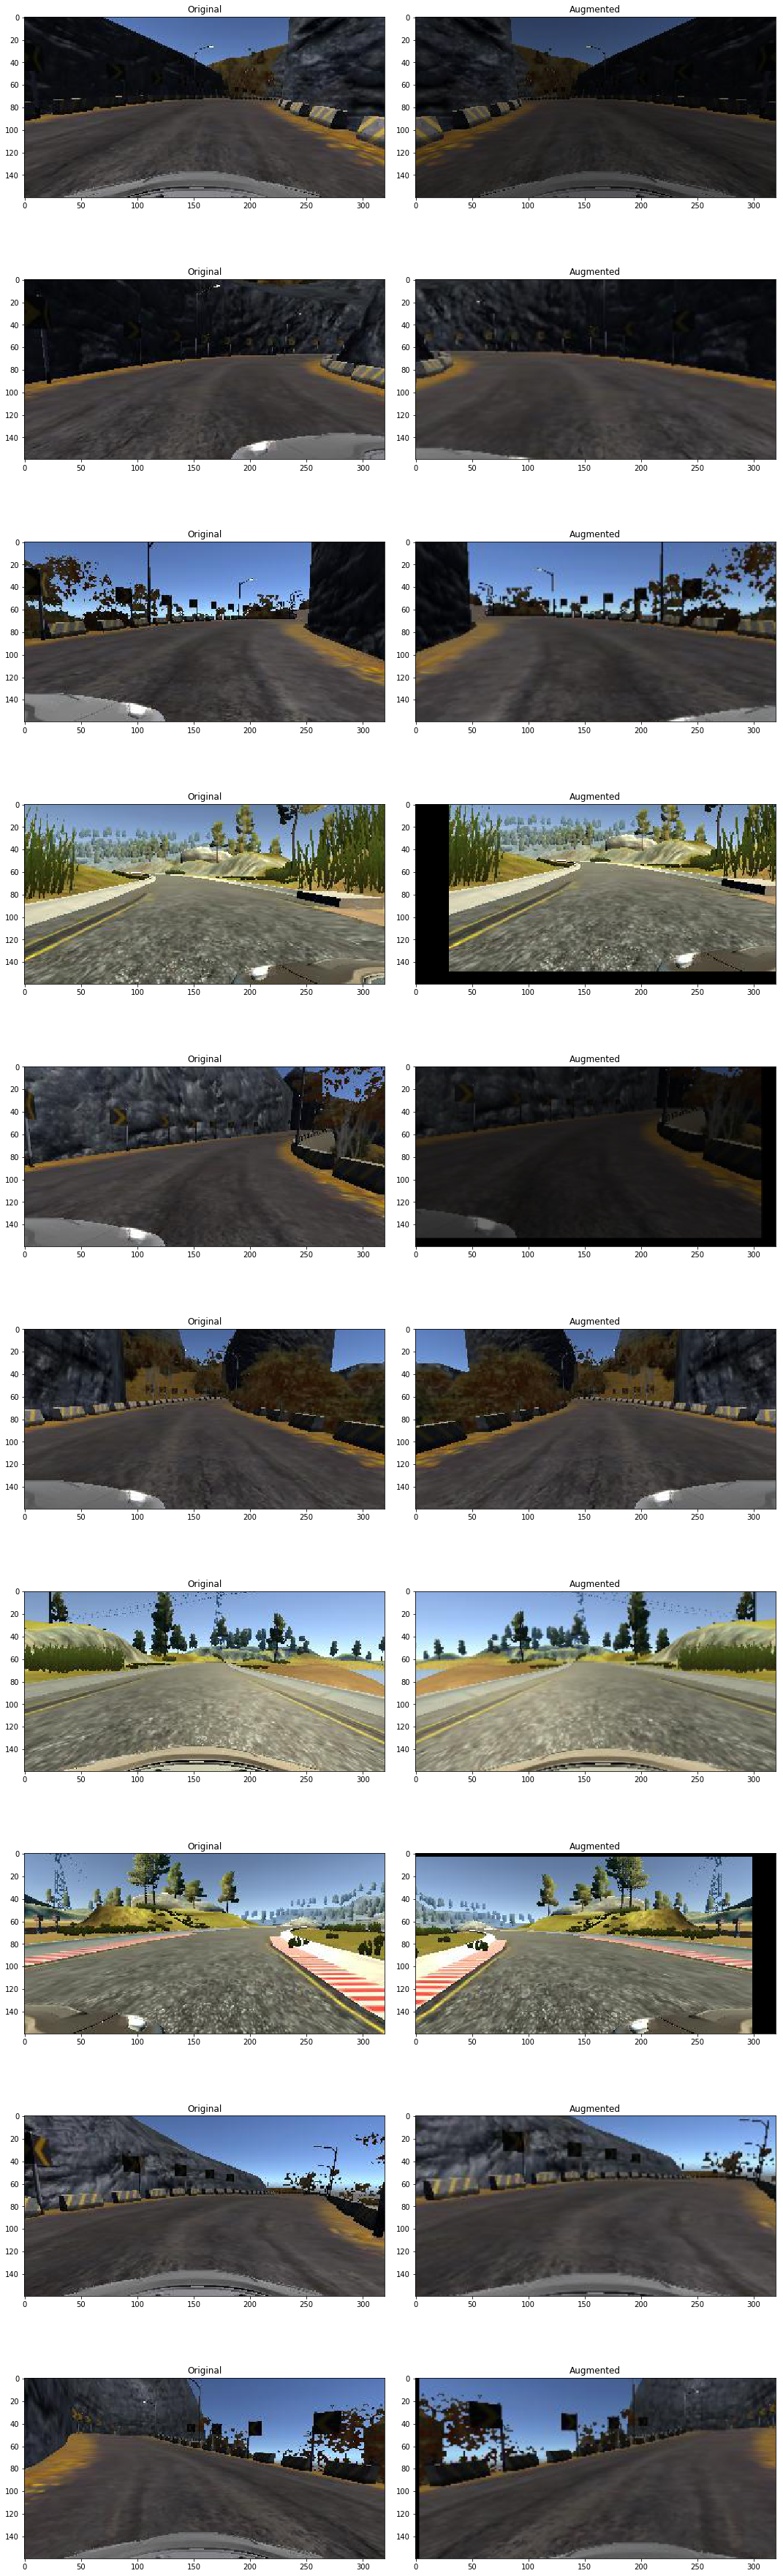

In [19]:
ncols = 2
nrow = 10
fig, axis = plt.subplots(nrow, ncols, figsize=(15, 50))
fig.tight_layout()

for i in range(nrow):
    randnum = random.randint(0, len(image_paths) - 1)
    random_image = image_paths[randnum]
    random_steering = steerings[randnum]
    
    original_image = mpimg.imread(random_image)
    augmented_image, steering = random_augment(random_image, random_steering)
    
    axis[i][0].imshow(original_image)
    axis[i][0].set_title("Original")
    
    axis[i][1].imshow(augmented_image)
    axis[i][1].set_title("Augmented")

In [20]:
def img_preprocess(img):
    img = img[40:140,:,:]  # Cropping
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.GaussianBlur(img, (3, 3), 0)
    img = cv2.resize(img, (200, 66))
    img = img / 255
    return img

Text(0.5,1,'Preprocess image')

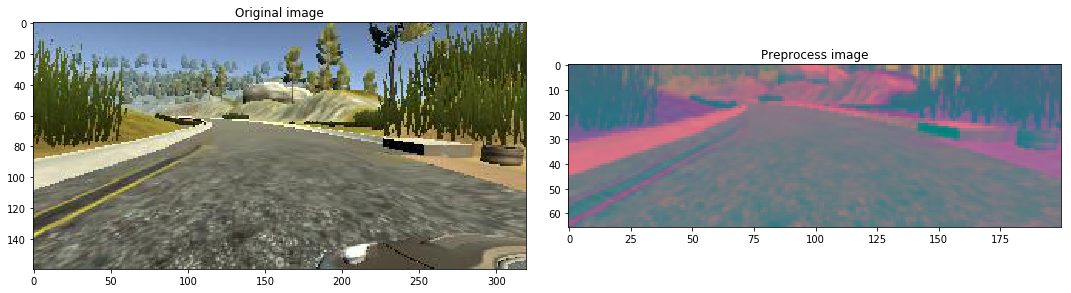

In [21]:
image = image_paths[100]
original_image = mpimg.imread(image)
preprocess_image = img_preprocess(original_image)

fig, axis = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(original_image)
axis[0].set_title("Original image")
axis[1].imshow(preprocess_image)
axis[1].set_title("Preprocess image")

## Manually batch generator

In [22]:
def batch_generator(image_paths, steering_ang, batch_size, istraining):
    while True:
        batch_img = []
        batch_steering = []
        
        for i in range(batch_size):
            random_index = random.randint(0, len(image_paths) - 1)
            if istraining:
                im, steering = random_augment(image_paths[random_index], steering_ang[random_index])
            else:
                im = mpimg.imread(image_paths[random_index])
                steering = steering_ang[random_index]
            im = img_preprocess(im)
            batch_img.append(im)
            batch_steering.append(steering)
        
        yield np.asarray(batch_img), np.asarray(batch_steering)

In [23]:
# class CustomDataGenerator(k.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, features, target, batch_size=128, dim=(66, 200), n_channels=3, shuffle=True, is_training=True):
#         'Initialization'
#         self.dim = dim
#         self.batch_size = batch_size
#         self.target = target
#         self.features = features
#         self.n_channels = n_channels
#         self.shuffle = shuffle
#         self.is_training = is_training
#         self.on_epoch_end()
        
#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.features) / self.batch_size))
    
#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index * self.batch_size: (index + 1) * self.batch_size]

#         # Find list of features
#         data_temp = [(self.features[k], k) for k in indexes]

#         # Generate data
#         X, y = self.__data_generation(data_temp)

#         return X, y
    
    
#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.features))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)
    
#     def __data_generation(self, data_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size), dtype=float)

#         # Generate data
#         for i, data in enumerate(data_temp):
#             feature, index = data
#             if self.is_training:
#                 im, steering = random_augment(feature, self.target[index])
#             else:
#                 im = mpimg.imread(feature)
#                 steering = self.target[index]
#             im = img_preprocess(im)
            
#             X[i,] = im
#             y[i] = self.target[index]

#         return X, y
        

Text(0.5,1,'Validation')

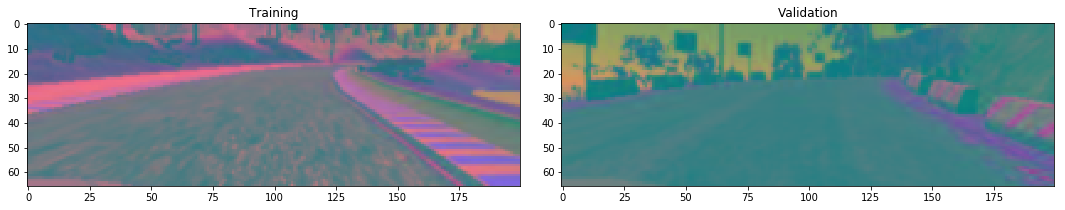

In [24]:
x_train_gen, y_train_gen = next(batch_generator(X_train, y_train, 1, 1))
x_val_gen, y_val_gen = next(batch_generator(X_valid, y_valid, 1, 0))


fig, axis = plt.subplots(1, 2, figsize=(15, 10))
fig.tight_layout()
axis[0].imshow(x_train_gen[0])
axis[0].set_title('Training')
axis[1].imshow(x_val_gen[0])
axis[1].set_title('Validation')

In [25]:
print(X_train.shape)

(11448,)


## Nvidia model architecture

https://devblogs.nvidia.com/deep-learning-self-driving-cars/

In [26]:
def nvidia_model():
    model = Sequential()
    model.add(Conv2D(24, kernel_size=(5, 5), strides=(2, 2), input_shape=(66, 200, 3), activation='elu'))
    model.add(Conv2D(36, kernel_size=(5, 5), strides=(2, 2), activation="elu"))
    model.add(Conv2D(48, kernel_size=(5, 5), strides=(2, 2), activation="elu"))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="elu"))
    model.add(Conv2D(64, kernel_size=(3, 3), activation="elu"))
#     model.add(Dropout(0.5))
    
    model.add(Flatten())
    model.add(Dense(100, activation="elu"))
#     model.add(Dropout(0.3))
    model.add(Dense(50, activation="elu"))
#     model.add(Dropout(0.5))
    model.add(Dense(10, activation="elu"))
#     model.add(Dropout(0.5))
    
    model.add(Dense(1))
    model.compile(loss="mse", optimizer=Adam(lr=1e-3))
    return model

In [27]:
model = nvidia_model()
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 31, 98, 24)        1824      
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 47, 36)        21636     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 5, 22, 48)         43248     
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 3, 20, 64)         27712     
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 1, 18, 64)         36928     
_________________________________________________________________
flatten_1 (Flatten)          (None, 1152)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               115300    
__________

In [28]:
# h = model.fit_generator(CustomDataGenerator(X_train, y_train, is_training=True), 
#                         steps_per_epoch=300, epochs=10, 
#                         validation_data=CustomDataGenerator(X_valid, y_valid, is_training=False), 
#                         validation_steps=200)

In [29]:
h = model.fit_generator(batch_generator(X_train, y_train, batch_size=128, istraining=1), 
                        steps_per_epoch=300, epochs=10, 
                        validation_data=batch_generator(X_valid, y_valid, 128, 0), 
                        validation_steps=200, shuffle=1)

Epoch 1/10
300/300 [==============================] - 112s 373ms/step - loss: 0.0960 - val_loss: 0.0405
Epoch 2/10
300/300 [==============================] - 107s 355ms/step - loss: 0.0539 - val_loss: 0.0398
Epoch 3/10
300/300 [==============================] - 107s 357ms/step - loss: 0.0439 - val_loss: 0.0291
Epoch 4/10
300/300 [==============================] - 110s 365ms/step - loss: 0.0384 - val_loss: 0.0293
Epoch 5/10
300/300 [==============================] - 112s 375ms/step - loss: 0.0354 - val_loss: 0.0281
Epoch 6/10
300/300 [==============================] - 108s 360ms/step - loss: 0.0337 - val_loss: 0.0278
Epoch 7/10
300/300 [==============================] - 108s 359ms/step - loss: 0.0328 - val_loss: 0.0249
Epoch 8/10
300/300 [==============================] - 108s 359ms/step - loss: 0.0315 - val_loss: 0.0279
Epoch 9/10
300/300 [==============================] - 115s 385ms/step - loss: 0.0311 - val_loss: 0.0267
Epoch 10/10
300/300 [==============================] - 116s 385m

## Evaluation

Text(0.5,0,'Epoch')

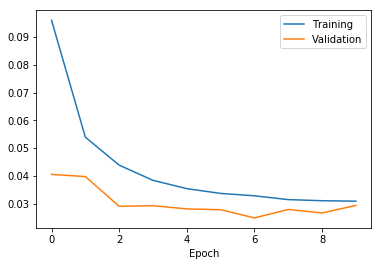

In [30]:
plt.plot(h.history["loss"])
plt.plot(h.history["val_loss"])
plt.legend(["Training", "Validation"])
plt.xlabel("Epoch")

In [31]:
model.save("keras-model.h5")

In [32]:
sess.close()